# Preprocessing

## Loading data / packages

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import bigfish.detection as detection

# RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-10-09 - SeqFISH_Run10 - HeLa-Puro_POLR2" 
RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-09-03 - SeqFISH_Run8 - HeLa_POLR2"

OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [29]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather")
Spots = pd.read_feather(RUN_PATH + "/result_tables/Spots.feather")
Drift = pd.read_feather(RUN_PATH + "/result_tables/Drift.feather")
Gene_map = pd.read_feather(RUN_PATH + "/result_tables/Gene_map.feather")

## Spots filtering

### Washout

In [30]:
check_len = len(Spots)
Spots = Spots.loc[~Spots['is_washout']]
print(f"{check_len - len(Spots)} spots filtered.")

1344 spots filtered.


### Out of segmentation

In [31]:
check_len = len(Spots)
Spots = Spots.loc[Spots['cell_label'] != 0]
print(f"{check_len - len(Spots)} spots filtered.")

37093 spots filtered.


## Data merge

In [32]:
check_len = len(Detection)
Detection = pd.merge(
    Detection,
    Acquisition.loc[:,['acquisition_id', 'cycle', 'location']],
    on= 'acquisition_id',
    suffixes=('','_acquisition')
)
assert len(Detection) == check_len

Detection = pd.merge(
    Detection,
    Gene_map.loc[:,['cycle','color_id','target']],
    on= ['cycle','color_id']
)
assert len(Detection) == check_len

check_len = len(Spots)
Spots = pd.merge(
    Spots,
    Detection.loc[:,['detection_id', 'acquisition_id', 'target', 'location']],
    on= 'detection_id'
)
assert len(Spots) == check_len


# General clustering

Here we perform DBSCAN algorithm by pulling together spots from all channels so as to identify site of interaction between channels

- can we produce a 3D heatmap showing density of spots per pixel ?
- add new multichannel clusters to viewer
- additional graph analysis

*Note : functional version of this code available in **density.py***

## Post-processing

### Parameters

In [33]:
VOXEL_SIZE = tuple(Detection['voxel_size'].iat[0])
VOXEL_SIZE = [int(i) for i in VOXEL_SIZE]

MIN_NB_CLUSTER = 3 # Number for multiRNA cluster analysis

CLUSTER_RADIUS = max(VOXEL_SIZE) # Colocalization analysis
# CLUSTER_RADIUS = Detection['cluster_size'].iat[0] # regular clustering

### Pooling data

In [34]:
spots_coordinates_per_fov = Spots.groupby(['location']).agg({
    'z' : list,
    'y' : list,
    'x' : list,
    })
spots_coordinates_per_fov

z  \
location                                                         
Location-01  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-02  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-03  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-04  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-05  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-06  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-07  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-08  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-09  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-10  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   

                                                             y  \
location                                                         
Location-01  [0, 77, 141, 144, 265, 282, 284, 291, 305, 349...   
Location-02  [4, 26, 35, 46, 53, 54, 56, 74, 105, 118, 121,...   
Location-03  [8, 20, 32, 45, 64, 79, 84, 84, 86, 89, 96, 11...   
Location-04  [14, 21, 28, 29, 33, 33, 40, 54, 55, 57, 58, 5...   
Location-05  [0, 10, 16, 76, 77, 96, 97, 111, 112, 128, 134...   
Location-06  [10, 28, 33, 127, 170, 174, 244, 248, 253, 255...   
Location-07  [201, 202, 241, 250, 250, 268, 275, 313, 316, ...   
Location-08  [3, 128, 137, 143, 158, 160, 178, 211, 215, 22...   
Location-09  [50, 56, 60, 60, 104, 117, 119, 119, 122, 127,...   
Location-10  [48, 115, 153, 320, 329, 478, 484, 487, 491, 4...   

                                                             x  
location                                                        
Location-01  [597, 389, 993, 1107, 673, 617, 575, 208, 648,...  
Location-02  [1266, 531, 1282, 1236, 1234, 693, 556, 1260, ...  
Location-03  [699, 1219, 640, 642, 728, 942, 962, 1309, 721...  
Location-04  [266, 1104, 350, 332, 305, 1082, 279, 1044, 58...  
Location-05  [1043, 1018, 1047, 1004, 1146, 1094, 1106, 163...  
Location-06  [92, 100, 77, 837, 1146, 1200, 254, 62, 814, 1...  
Location-07  [1101, 1579, 373, 400, 1099, 1128, 1180, 728, ...  
Location-08  [25, 716, 668, 693, 598, 520, 668, 609, 625, 5...  
Location-09  [1755, 1711, 1757, 1762, 1900, 1861, 1840, 187...  
Location-10  [939, 1379, 210, 981, 984, 965, 666, 960, 904,...

### DBSCAN

In [35]:
Spots_clustered = pd.DataFrame(columns=['cluster_id','z','y','x', 'location'])
for location in spots_coordinates_per_fov.index : 
    data_selec = spots_coordinates_per_fov.loc[location]

    spots = np.array(
        list(zip(data_selec['z'],data_selec['y'],data_selec['x'],)),
        dtype=int)

    clustered_spot, clusters = detection.detect_clusters(
        spots,
        VOXEL_SIZE,
        CLUSTER_RADIUS,
        MIN_NB_CLUSTER,
    )

    z,y,x, cluster_id = zip(*clustered_spot)
    cluster_z, cluster_y, cluster_x, spot_number, cluster_index = zip(*clusters)

    new_Spots_clustered = pd.DataFrame({
            'cluster_id' : cluster_id,
            'z' : z,
            'y' : y,
            'x' : x,
            'location' : location,
        })
    
    new_Clusters = pd.DataFrame({
        'cluster_id' : cluster_index,
        'cluster_centroid_z' : cluster_z, 
        'cluster_centroid_y' : cluster_y, 
        'cluster_centroid_x' : cluster_x, 
    })

    check_len = len(new_Spots_clustered)
    new_Spots_clustered = pd.merge(
        new_Spots_clustered,
        new_Clusters,
        on='cluster_id',
        how='left',
        validate='m:1'
    )
    assert len(new_Spots_clustered) == check_len , "check for duplication"

    Spots_clustered = pd.concat([
        Spots_clustered,
        new_Spots_clustered,
    ], axis= 0)

Spots_clustered

cluster_id   z     y     x     location  cluster_centroid_z  \
0             -1   5     0   597  Location-01                 NaN   
1             -1   5    77   389  Location-01                 NaN   
2             -1   5   141   993  Location-01                 NaN   
3             -1   5   144  1107  Location-01                 NaN   
4             -1   5   265   673  Location-01                 NaN   
...          ...  ..   ...   ...          ...                 ...   
31801         -1  47   867  1705  Location-10                 NaN   
31802         -1  47  1463   583  Location-10                 NaN   
31803         -1  47  1656   934  Location-10                 NaN   
31804         -1  48  1786  1581  Location-10                 NaN   
31805        240  48  1299   621  Location-10                47.0   

       cluster_centroid_y  cluster_centroid_x  
0                     NaN                 NaN  
1                     NaN                 NaN  
2                     NaN                 NaN  
3                     NaN                 NaN  
4                     NaN                 NaN  
...                   ...                 ...  
31801                 NaN                 NaN  
31802                 NaN                 NaN  
31803                 NaN                 NaN  
31804                 NaN                 NaN  
31805              1299.0               621.0  

[300295 rows x 8 columns]

### Duplicated values after clustering

This dataframe is expected to contain duplicated values for spots with perfect colocalization. What is important for downstream analysis is that they have the same cluster_id. Next step is to retrieve this cluster id to the main Spots table, to avoid duplication during merge on coordinates, we remove duplicated rows.

In [36]:
Spots_clustered[Spots_clustered.duplicated()]

cluster_id   z     y     x     location  cluster_centroid_z  \
1505          -1   6   380  1212  Location-01                 NaN   
1522           7   6   867   383  Location-01                 6.0   
1537          -1   5  1040   538  Location-01                 NaN   
1553           8   5  1115   779  Location-01                 5.0   
1557          -1   7  1114   747  Location-01                 NaN   
...          ...  ..   ...   ...          ...                 ...   
31294         -1  17  1621   557  Location-10                 NaN   
31355         -1  20   600    63  Location-10                 NaN   
31462        236  25   844   501  Location-10                24.0   
31741         -1  43   482   251  Location-10                 NaN   
31767         -1  43   426  1227  Location-10                 NaN   

       cluster_centroid_y  cluster_centroid_x  
1505                  NaN                 NaN  
1522                867.0               383.0  
1537                  NaN                 NaN  
1553               1115.0               779.0  
1557                  NaN                 NaN  
...                   ...                 ...  
31294                 NaN                 NaN  
31355                 NaN                 NaN  
31462               844.0               501.0  
31741                 NaN                 NaN  
31767                 NaN                 NaN  

[4564 rows x 8 columns]

In [37]:
prev_len = len(Spots_clustered)
Spots_clustered = Spots_clustered.drop_duplicates()
print("{0} duplicates dropped.".format(prev_len - len(Spots_clustered)))

4564 duplicates dropped.


### Merging data into main Spots frame

In [38]:
check_len = len(Spots) #No filter/duplication expected.

Spots_clustered = Spots_clustered.rename(columns={'cluster_id' : 'general_cluster_id'})
print("clustered :",len(Spots_clustered))

Spots = pd.merge(
    Spots,
    Spots_clustered,
    on=['location','z','y','x'],
    validate= 'm:1'
)

assert len(Spots) == check_len
Spots

clustered : 295731


spot_id  cluster_id  drifted_z  drifted_y  drifted_x  intensity  \
0             0         NaN          5          0        597       5927   
1             1         NaN          5         77        389       6095   
2             2         NaN          5        141        993       6923   
3             3         NaN          5        144       1107       6960   
4             4         NaN          5        265        673       7111   
...         ...         ...        ...        ...        ...        ...   
300290   338724         NaN         47        867       1705       4061   
300291   338726         NaN         47       1463        583       4628   
300292   338728         NaN         47       1656        934       4044   
300293   338729         NaN         48       1786       1581       4024   
300294   338731         6.0         48       1299        621       4413   

       population  detection_id  acquisition_id_x  drift_z  ...  \
0            free             1                 0        0  ...   
1            free             1                 0        0  ...   
2            free             1                 0        0  ...   
3            free             1                 0        0  ...   
4            free             1                 0        0  ...   
...           ...           ...               ...      ...  ...   
300290       free           208               189        0  ...   
300291       free           208               189        0  ...   
300292       free           208               189        0  ...   
300293       free           208               189        0  ...   
300294  clustered           208               189        0  ...   

             coordinates  in_nucleus  cell_label  acquisition_id_y  target  \
0            [5, 0, 597]        True         2.0                 0  POLR2A   
1           [5, 77, 389]       False         1.0                 0  POLR2A   
2          [5, 141, 993]       False         5.0                 0  POLR2A   
3         [5, 144, 1107]        True         5.0                 0  POLR2A   
4          [5, 265, 673]        True         6.0                 0  POLR2A   
...                  ...         ...         ...               ...     ...   
300290   [47, 867, 1705]       False        19.0               189  POLR2L   
300291   [47, 1463, 583]        True        27.0               189  POLR2L   
300292   [47, 1656, 934]       False        37.0               189  POLR2L   
300293  [48, 1786, 1581]       False        39.0               189  POLR2L   
300294   [48, 1299, 621]        True        38.0               189  POLR2L   

           location general_cluster_id cluster_centroid_z  cluster_centroid_y  \
0       Location-01                 -1                NaN                 NaN   
1       Location-01                 -1                NaN                 NaN   
2       Location-01                 -1                NaN                 NaN   
3       Location-01                 -1                NaN                 NaN   
4       Location-01                 -1                NaN                 NaN   
...             ...                ...                ...                 ...   
300290  Location-10                 -1                NaN                 NaN   
300291  Location-10                 -1                NaN                 NaN   
300292  Location-10                 -1                NaN                 NaN   
300293  Location-10                 -1                NaN                 NaN   
300294  Location-10                240               47.0              1299.0   

       cluster_centroid_x  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
300290                NaN  
300291                NaN  
300292                NaN  
300293                NaN  
300294              621.0  

[300295 rows x 31 columns]

# Analysis

### Data grouping

In [39]:
Clustered_spots = Spots.loc[Spots['general_cluster_id'] != -1]

multichannel_clusters = Clustered_spots.groupby(['location', 'general_cluster_id']).aggregate({
    'spot_id' : 'count',
    'target' : ['nunique','unique'],
    'cluster_centroid_z' : 'first',
    'cluster_centroid_y' : 'first',
    'cluster_centroid_x' : 'first',
})

multichannel_clusters.columns = pd.Index(['spot number', 'rna number', 'rna list', 'z', 'y', 'x'])

multichannel_clusters.to_excel(OUTPUT_PATH + "Multichannel_cluster.xlsx")
multichannel_clusters

spot number  rna number  \
location    general_cluster_id                            
Location-01 0                             6           4   
            1                             3           1   
            2                             3           1   
            3                             3           1   
            4                             3           1   
...                                     ...         ...   
Location-10 239                           4           1   
            240                           3           1   
            241                           3           1   
            242                           3           1   
            243                           3           1   

                                                        rna list     z  \
location    general_cluster_id                                           
Location-01 0                   [POLR2A, POLR2E, POLR2F, POLR2H]   5.0   
            1                                           [POLR2A]  18.0   
            2                                           [POLR2A]  22.0   
            3                                           [POLR2A]  23.0   
            4                                           [POLR2A]  23.0   
...                                                          ...   ...   
Location-10 239                                         [POLR2L]  46.0   
            240                                         [POLR2L]  47.0   
            241                                         [POLR2L]  16.0   
            242                                         [POLR2L]  26.0   
            243                                         [POLR2L]  33.0   

                                     y       x  
location    general_cluster_id                  
Location-01 0                    351.0   964.0  
            1                   1179.0   762.0  
            2                    202.0   357.0  
            3                    524.0   145.0  
            4                   1446.0  1759.0  
...                                ...     ...  
Location-10 239                  751.0   374.0  
            240                 1299.0   621.0  
            241                   97.0  1859.0  
            242                 1497.0    30.0  
            243                 1389.0   242.0  

[2806 rows x 6 columns]

In [40]:
updated_spots = pd.merge(
    Spots,
    multichannel_clusters.loc[:,['rna number']],
    on=['location','general_cluster_id'],
)
assert len(Spots[Spots['general_cluster_id'] != -1]) == len(updated_spots), "Non unique (location,general_cluster_id)"
updated_spots

spot_id  cluster_id  drifted_z  drifted_y  drifted_x  intensity  \
0           10         NaN          5        353        964       7341   
1        13745         NaN          5        353        964      10348   
2        13744         NaN          5        352        963      11054   
3        17550         NaN          5        350        965      10877   
4        17551         NaN          5        351        964      10644   
...        ...         ...        ...        ...        ...        ...   
11152   338102         9.0         17         97       1860       7029   
11153   338106         9.0         16         97       1860       6880   
11154   338302        10.0         26       1497         30       6526   
11155   338303        10.0         26       1496         30       6371   
11156   338304        10.0         26       1498         30       6232   

      population  detection_id  acquisition_id_x  drift_z  ...  in_nucleus  \
0           free             1                 0        0  ...        True   
1           free             7                60        0  ...        True   
2           free             7                60        0  ...        True   
3           free             9                80        0  ...       False   
4           free             9                80        0  ...        True   
...          ...           ...               ...      ...  ...         ...   
11152  clustered           208               189        0  ...        True   
11153  clustered           208               189        0  ...        True   
11154  clustered           208               189        0  ...        True   
11155  clustered           208               189        0  ...        True   
11156  clustered           208               189        0  ...        True   

       cell_label  acquisition_id_y  target     location general_cluster_id  \
0             8.0                 0  POLR2A  Location-01                  0   
1             8.0                60  POLR2E  Location-01                  0   
2             8.0                60  POLR2E  Location-01                  0   
3             8.0                80  POLR2F  Location-01                  0   
4             8.0                80  POLR2F  Location-01                  0   
...           ...               ...     ...          ...                ...   
11152        40.0               189  POLR2L  Location-10                241   
11153        40.0               189  POLR2L  Location-10                241   
11154        43.0               189  POLR2L  Location-10                242   
11155        43.0               189  POLR2L  Location-10                242   
11156        43.0               189  POLR2L  Location-10                242   

      cluster_centroid_z cluster_centroid_y  cluster_centroid_x rna number  
0                    5.0              351.0               964.0          4  
1                    5.0              351.0               964.0          4  
2                    5.0              351.0               964.0          4  
3                    5.0              351.0               964.0          4  
4                    5.0              351.0               964.0          4  
...                  ...                ...                 ...        ...  
11152               16.0               97.0              1859.0          1  
11153               16.0               97.0              1859.0          1  
11154               26.0             1497.0                30.0          1  
11155               26.0             1497.0                30.0          1  
11156               26.0             1497.0                30.0          1  

[11157 rows x 32 columns]

## General Plots

### Number of cluster with n number of RNA

In [41]:
cluster_plurality_number = multichannel_clusters['rna number'].unique()
cluster_plurality_number = list(cluster_plurality_number)
cluster_plurality_number.sort()
print(f"{len(cluster_plurality_number)} different size of cluster found.")
cluster_plurality_number

9 different size of cluster found.


[1, 2, 3, 4, 5, 6, 7, 9, 10]

### Total rna number VS diversity of cluster

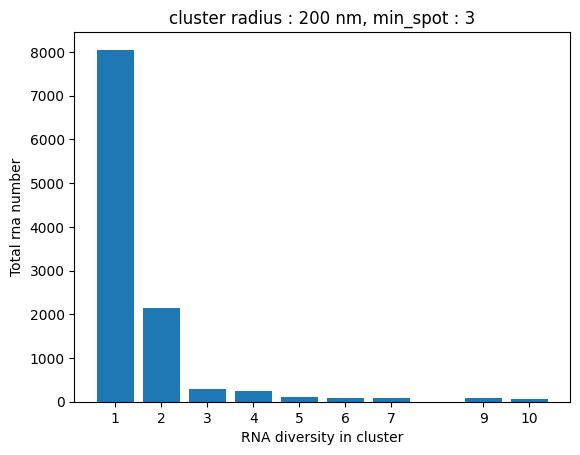

In [42]:
fig = plt.figure()
ax = fig.gca()

data = multichannel_clusters.groupby("rna number")['spot number'].sum()
ax.bar(data.index, data, align='center')
ax.set_xticks(data.index)
ax.set_ylabel("Total rna number")
ax.set_xlabel("RNA diversity in cluster")
ax.set_title(f"cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

plt.show()

### Total rna number per RNA per diversity

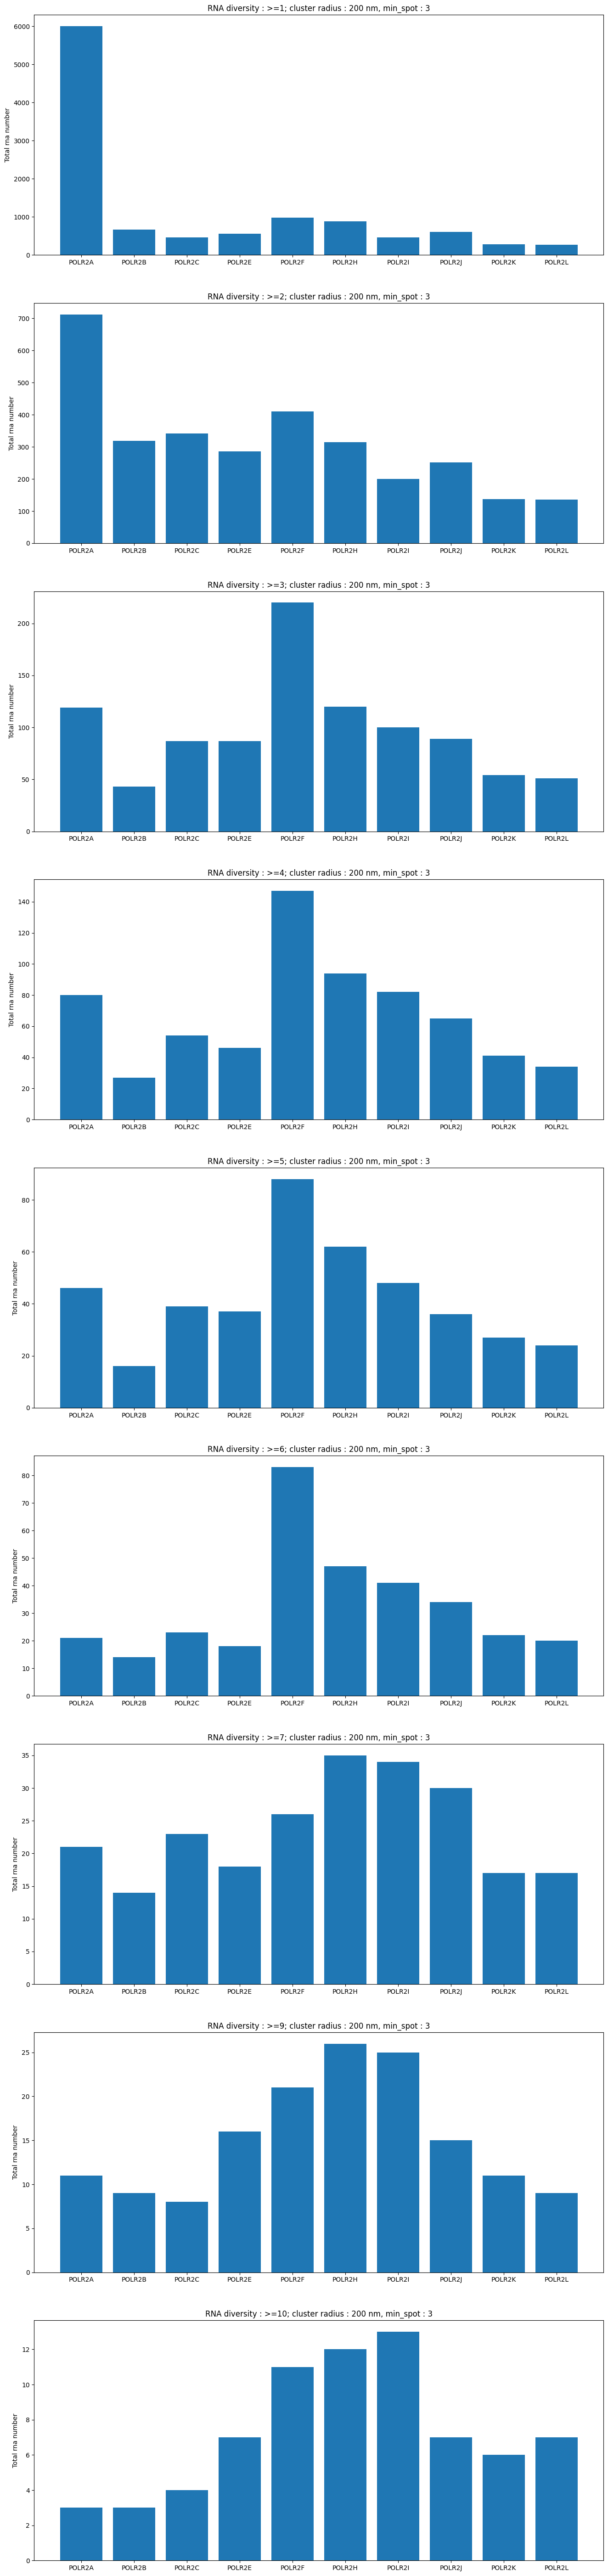

In [43]:
fig, axes = plt.subplots(nrows= len(cluster_plurality_number), ncols=1, figsize = (16,8*len(cluster_plurality_number)))

for ax, dimension in zip(axes, cluster_plurality_number) :
    ax:plt.Axes
    ax.set_title(f"RNA diversity : >={dimension}; cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

    data = updated_spots.loc[updated_spots['rna number'] >= dimension]
    data = data.groupby('target')['spot_id'].count()


    X = list(range(len(data)))
    ax.bar(X, data,align='center')
    ax.set_xticks(X, labels=data.index)
    ax.set_ylabel("Total rna number")

plt.show()

## Affinity & presence


### Cluster unity table

Here we build a DataFrame showing for each cluster the number of single molecules from each RNA in the dataset

In [44]:
MIN_DIVERSITY = 3

In [45]:
#Filtering spots from cluster with less than MIN_DIVERSITY different rnas.
data = updated_spots.loc[updated_spots['rna number'] >= MIN_DIVERSITY]

#Init empty table : each line is a cluster and each RNA of data set are reprensented in columns with their single molecule number in this cluster; init to 0.
cluster_list = pd.Series(zip(data['location'], data['general_cluster_id'])).unique()
cluster_list = pd.MultiIndex.from_tuples(cluster_list)
RNA_list = data['target'].unique()
cluster_unity_counts = pd.DataFrame(index=cluster_list, columns=RNA_list, dtype=int, data=0).sort_index()

#Creating table with all counts of single molecule per cluster per rna
agg_table = data.groupby(['location', 'general_cluster_id','target'])['spot_id'].count()
for location, cluster_id, rna in agg_table.index :
    value = agg_table.at[(location,cluster_id,rna)]
    cluster_unity_counts.loc[(location,cluster_id), rna] += value

#Assign values from groupby to cluster table
total = cluster_unity_counts.sum(axis=1).astype(int)
cluster_unity_counts

POLR2A  POLR2E  POLR2F  POLR2H  POLR2B  POLR2C  POLR2J  \
Location-01 0         1       2       2       1       0       0       0   
            83        1       1       0       0       0       1       0   
            85        0       0       1       0       0       1       0   
            99        0       1       1       0       0       2       0   
            113       1       0       1       0       1       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
Location-09 231       0       1       0       1       0       1       0   
            232       0       2       3       0       0      11       0   
            251       0       0       1       0       0       0       1   
            290       0       0       1       0       1       0       0   
Location-10 143       1       1       0       0       0       1       0   

                 POLR2I  POLR2K  POLR2L  
Location-01 0         0       0       0  
            83        0       0       0  
            85        0       1       0  
            99        0       0       0  
            113       0       0       0  
...                 ...     ...     ...  
Location-09 231       0       0       0  
            232       0       0       0  
            251       0       1       1  
            290       0       1       0  
Location-10 143       0       0       0  

[105 rows x 10 columns]

### Affinity & Presence tables

In [46]:
presence_dict = {}
affinity_dict = {}

for rna in RNA_list :
    rna_index = cluster_unity_counts.loc[cluster_unity_counts[rna] > 0].index
    data = cluster_unity_counts.loc[rna_index]

    affinity_df = data.apply(lambda x : x/total.loc[rna_index])
    affinity_df_total = affinity_df.sum(axis=1).round(10)
    assert (affinity_df_total == 1).all(), affinity_df[affinity_df_total != 1]
    affinity_dict[rna] = affinity_df

    presence_df = data.apply(lambda x : x.astype(bool))
    presence_dict[rna] = presence_df



presence_df


POLR2A  POLR2E  POLR2F  POLR2H  POLR2B  POLR2C  POLR2J  \
Location-01 148   False   False   False   False   False   False    True   
            162   False   False   False    True   False   False    True   
            188   False    True   False   False   False   False    True   
Location-02 160   False   False   False    True    True    True   False   
            189   False   False    True    True   False   False    True   
Location-03 80     True   False   False    True    True    True    True   
            269   False   False    True    True   False   False    True   
            280   False   False    True    True   False   False   False   
            287   False   False   False    True   False   False    True   
            288   False   False   False    True   False   False   False   
            317   False   False   False   False   False   False    True   
Location-04 207   False    True    True    True   False   False    True   
            260   False   False   False    True   False   False   False   
Location-05 13     True    True    True    True    True    True    True   
            137   False    True    True    True   False   False    True   
            160   False   False   False    True   False   False    True   
            178    True   False   False   False   False   False    True   
Location-06 247   False    True   False   False   False   False    True   
            269   False   False   False    True   False   False    True   
            295   False   False   False   False   False   False    True   
            297   False   False   False   False   False   False    True   
            301   False   False   False   False   False   False    True   
            305   False   False   False   False   False   False    True   
            310   False   False   False   False   False   False    True   
            331   False   False   False   False   False   False    True   
Location-07 216   False    True   False   False   False    True   False   
            231   False    True    True   False   False   False   False   
            262   False   False    True    True   False   False    True   
Location-08 0      True   False    True    True    True   False   False   
            190    True    True   False   False    True   False   False   
            233   False   False    True    True   False   False   False   
            276   False   False   False    True   False   False   False   
            301   False   False   False   False   False   False    True   
            309   False   False   False   False   False   False    True   
Location-09 209    True    True    True    True    True    True    True   
            251   False   False    True   False   False   False    True   

                 POLR2I  POLR2K  POLR2L  
Location-01 148    True   False    True  
            162   False   False    True  
            188   False   False    True  
Location-02 160    True   False    True  
            189    True    True    True  
Location-03 80    False    True    True  
            269    True    True    True  
            280   False   False    True  
            287    True    True    True  
            288    True   False    True  
            317   False    True    True  
Location-04 207    True    True    True  
            260    True   False    True  
Location-05 13     True    True    True  
            137    True    True    True  
            160   False    True    True  
            178   False   False    True  
Location-06 247    True   False    True  
            269    True   False    True  
            295    True    True    True  
            297    True    True    True  
            301   False    True    True  
            305   False    True    True  
            310   False    True    True  
            331    True   False    True  
Location-07 216   False   False    True  
            231   False   False    True  
            262    True    True    True  
Location-08 0      True

### Presence plots

Shows for each rna when it was found in a cluster of often other RNA were found in that cluster

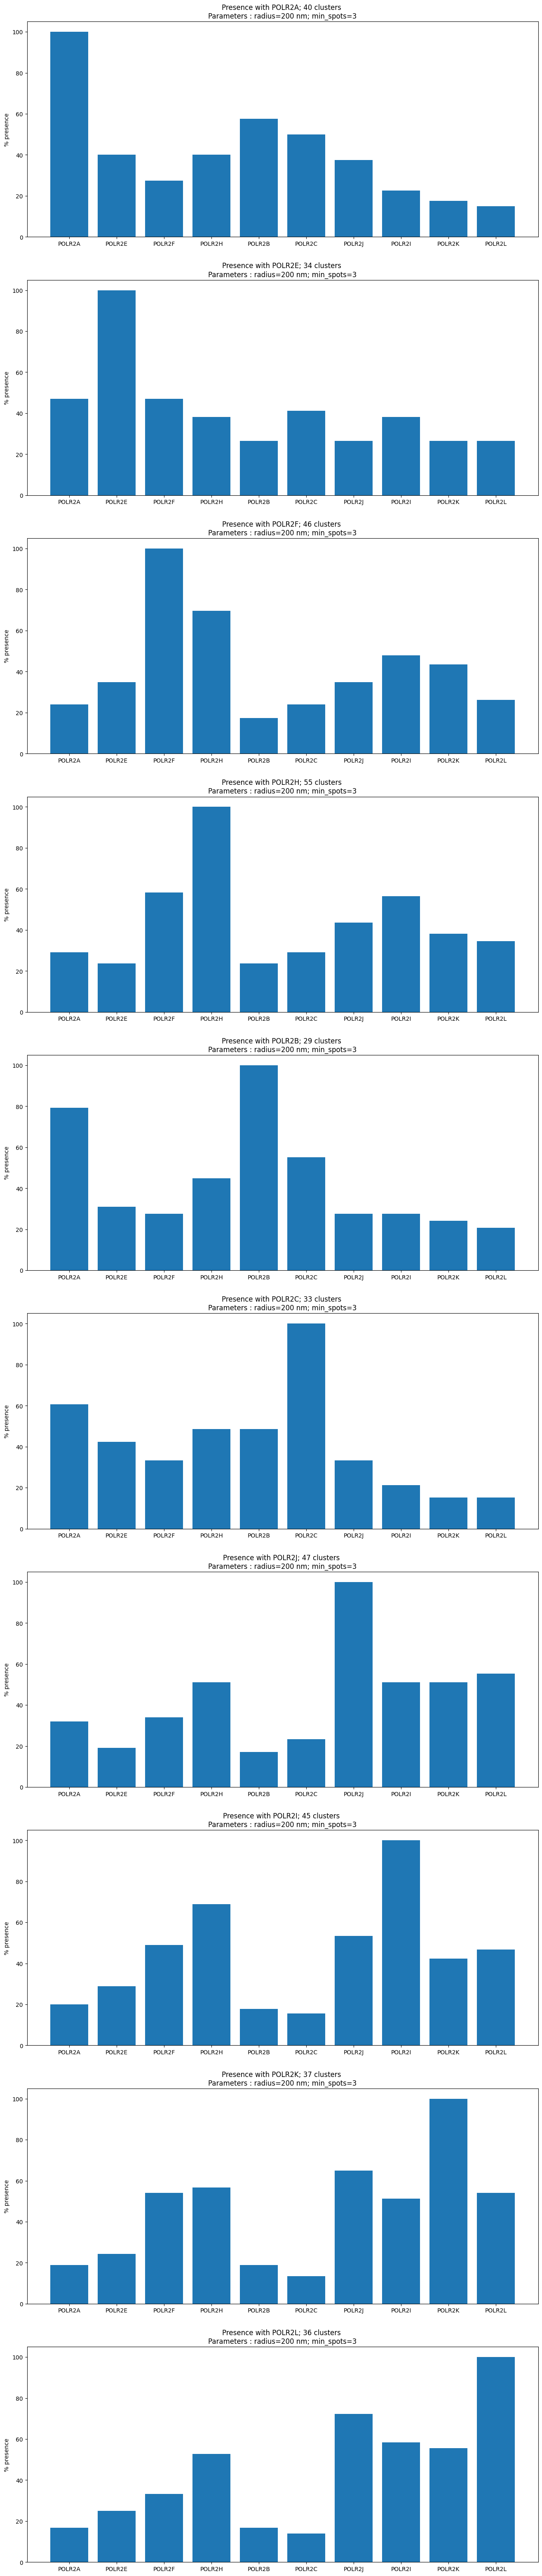

In [47]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = presence_dict[rna]
    cluster_number = len(data)
    data = data.sum(axis=0) / cluster_number * 100

    ax.set_title(f"Presence with {rna}; {cluster_number} clusters \nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("% presence")

plt.show()

### Affinity plots

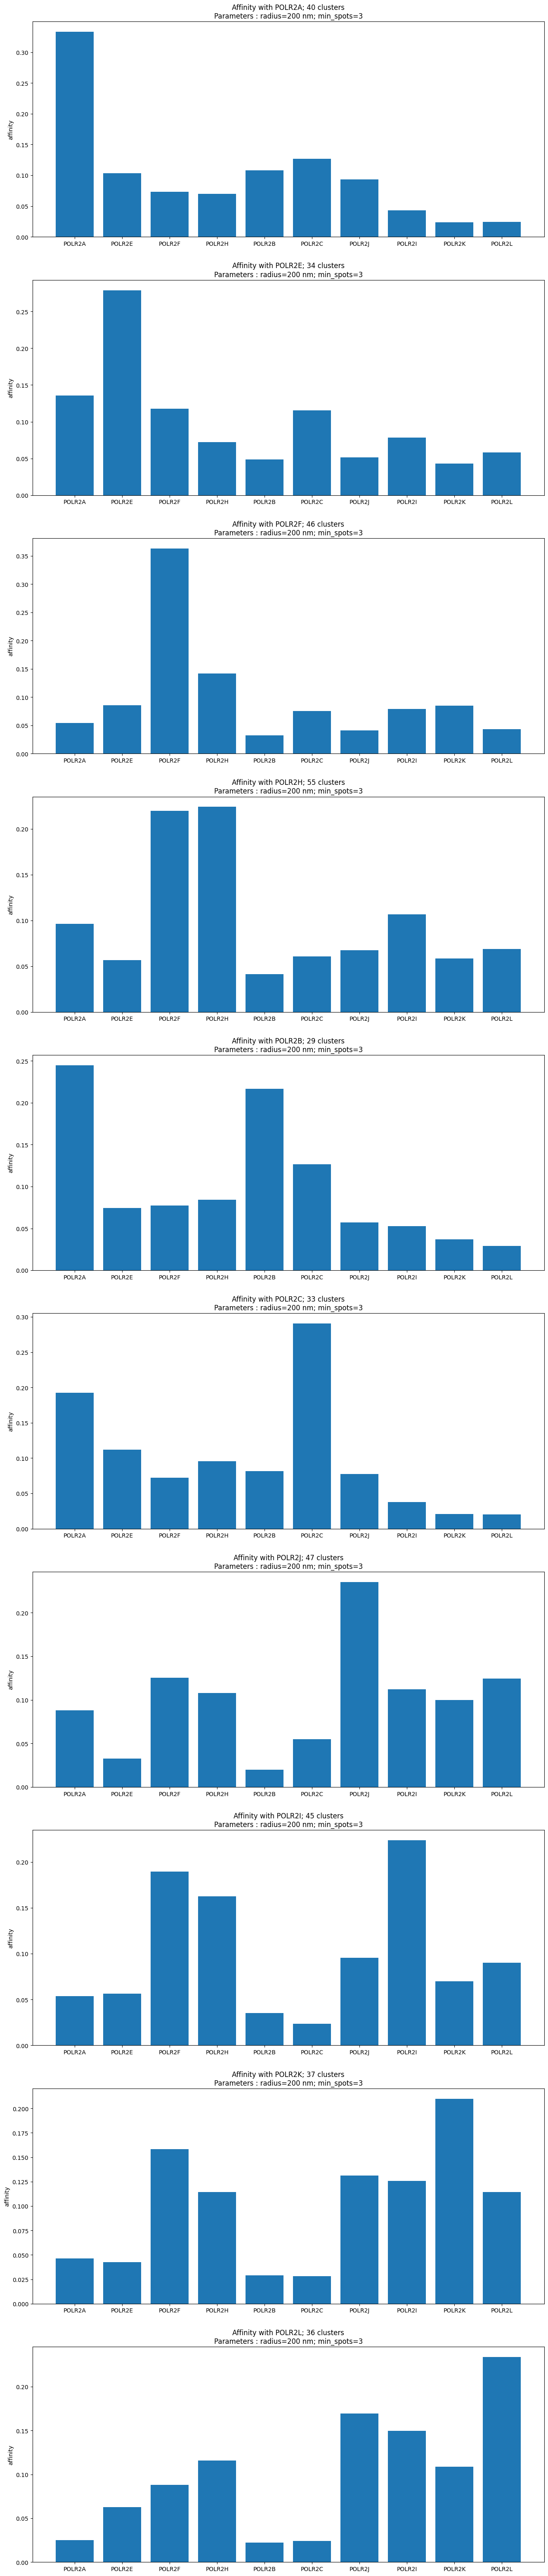

In [48]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = affinity_dict[rna]
    cluster_number = len(data)
    data = data.mean(axis=0)
    data_std = data.std(axis=0)

    ax.set_title(f"Affinity with {rna}; {cluster_number} clusters\nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("affinity")

plt.show()